In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

from analysis import *
from process import *

# Example cache directory path, it determines where downloaded data will be stored
output_dir = './ecephys_cache_dir/'

manifest_path = os.path.join(output_dir, "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

## Filter sessions data

In [2]:
filter_dict = {
    'session_type': 'brain_observatory_1.1',
    'full_genotype': 'Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt',
    'ecephys_structure_acronyms': 'VISp', # 'VISp', 'VISal' 
}

In [3]:
# sessions = cache.get_session_table()
# filtered_sessions = sessions[
#     np.logical_and.reduce([np.array([True if s in x else False for x in sessions[k]]) for k, s in filter_dict.items()])
# ]
# filtered_sessions

## Get session and probe

In [4]:
session_id = 721123822
session = cache.get_session_data(session_id)

In [5]:
VI_structure_acronyms = [x for x in cache.get_structure_acronyms() if x is not np.nan and 'VI' in x]
print(VI_structure_acronyms)
probes = cache.get_probes()
probes = probes[probes['ecephys_session_id'] == session_id]

for i, x in probes.iterrows():
    print(f'probe id: {i: d}')
    print('structure: ' + ', '.join([s for s in x['ecephys_structure_acronyms'] if s in VI_structure_acronyms]))

['VISrl', 'VIS', 'VISp', 'VISpm', 'VISam', 'VISal', 'VISl', 'VISmma', 'VISmmp', 'VISli']
probe id:  760213137
structure: VISam
probe id:  760213142
structure: VIS
probe id:  760213145
structure: VISp
probe id:  760213147
structure: VISl
probe id:  760213150
structure: VISal
probe id:  760213153
structure: VISrl


In [6]:
probes = session.probes
channels = session.channels
channels = channels.loc[channels['structure_acronym'] == filter_dict['ecephys_structure_acronyms']]
len(channels)

81

In [7]:
probe_id = channels.probe_id.unique()
probe_id

array([760213145], dtype=int64)

In [8]:
probe_id = probe_id[0]
channel_id = 850245985 # V1 850245985, AL 850247639
probe = probes.loc[probe_id]

In [9]:
fs = probe.lfp_sampling_rate

### Save data in selected channels

#### Average channels in groups

In [10]:
# import sklearn as sk
# from sklearn import manifold, cluster

# ccf_coords = ['anterior_posterior_ccf_coordinate', 'dorsal_ventral_ccf_coordinate', 'left_right_ccf_coordinate']
# channel_coord = channels[ccf_coords].values

# # reduce dimension to one
# method = 'ltsa' # 'standard' 'hessian' 'ltsa' 'modified'
# lle = manifold.LocallyLinearEmbedding(n_components=1, n_neighbors=6, method=method)
# probe_coord = lle.fit_transform(channel_coord) # 1D coordinate of channels

# # find number of clusters in the channels
# probe_coord = sk.preprocessing.MinMaxScaler().fit_transform(probe_coord)
# kmeans = cluster.KMeans(2, n_init='auto')
# jumps = kmeans.fit_predict(np.diff(np.sort(probe_coord, axis=0), axis=0))
# n_group = np.sum(jumps == np.argmax(kmeans.cluster_centers_.ravel())) + 1

# # divide channels into groups
# kmeans = cluster.KMeans(n_group, n_init='auto')
# channel_group = kmeans.fit_predict(probe_coord)
# group_centers = kmeans.cluster_centers_.ravel()
# group_sort_id = np.argsort(group_centers)

# # visualize channel groups
# plt.figure(figsize=(5, 4))
# for g, x in zip(channel_group, probe_coord.ravel()):
#     plt.plot(group_centers[g], x, 'b.', markersize=2)
# plt.show()

In [11]:
# # Load LFP given probe
# lfp_array = session.get_lfp(probe_id)
# lfp_array = lfp_array.sel(channel=np.unique(lfp_array.channel.sel(channel=channels.index, method='nearest')))

# # Compile groups of channels
# channels_group_id = np.zeros(channel_group.size, dtype=int)
# channels_in_groups = {}
# group_ccf_coord = np.zeros((n_group, 3))
# for i in range(n_group):
#     idx = channel_group == group_sort_id[i]
#     channels_group_id[idx] = i
#     group_ccf_coord[i, :] = channels[idx][ccf_coords].values.mean(axis=0)
#     channels_in_groups[i] = channels[idx].index.values
# channel_group_map = pd.DataFrame(channels_group_id, columns=['group_id'], index=channels.index)
# channel_group_map[ccf_coords] = group_ccf_coord[channels_group_id]
# for g, c in channels_in_groups.items():
#     channels_in_groups[g] = np.array([x for x in c if x in lfp_array.channel])

# # Create group average LFP dataset
# channel_group_ids = pd.Index(np.arange(n_group), name='group_id')
# group_lfp = [lfp_array.sel(channel=channels_in_groups[i]).mean(dim='channel') for i in channel_group_ids]
# group_lfp = xr.concat(group_lfp, dim=channel_group_ids).to_dataset(name='LFP')

# # Save data
# filepath = os.path.join(output_dir, 'session_%d' % session_id,
#                         'lfp_probe%d_%s_channel_groups.nc' % (probe_id, filter_dict['ecephys_structure_acronyms']))
# group_lfp.to_netcdf(filepath) # save downsampled channels
# channel_group_map.to_csv(filepath.replace('.nc', '.csv'))
# group_lfp

#### Save one particular channel

In [12]:
# lfp = session.get_lfp(probe_id).sel(channel=channel_id, method='nearest')
# filepath = os.path.join(output_dir, 'session_%d' % session_id, 'lfp_probe%d_channel%d.nc' % (probe_id, channel_id))
# lfp.to_netcdf(filepath)
# lfp

### Load channel

In [13]:
filepath = os.path.join(output_dir, 'session_%d' % session_id,
                        'lfp_probe%d_%s_channel_groups.nc' % (probe_id, filter_dict['ecephys_structure_acronyms']))
lfp_array = xr.open_dataset(filepath)
lfp_array = lfp_array.assign_attrs(fs=fs).rename(group_id='channel')
lfp_array

<xarray.Dataset>
Dimensions:  (time: 12263286, channel: 8)
Coordinates:
  * time     (time) float64 0.5328 0.5336 0.5344 ... 9.811e+03 9.811e+03
  * channel  (channel) int32 0 1 2 3 4 5 6 7
Data variables:
    LFP      (channel, time) float32 ...
Attributes:
    fs:       1249.99999145772

In [14]:
channel_group_map = pd.read_csv(filepath.replace('.nc', '.csv'), index_col='id')
group_dv_ccf = dict(zip(channel_group_map['group_id'], channel_group_map['dorsal_ventral_ccf_coordinate']))
group_id = channel_group_map.loc[channel_id, 'group_id']
channel_group_map

group_id  anterior_posterior_ccf_coordinate  \
id                                                       
850245925         7                        8545.625000   
850245931         7                        8545.625000   
850245937         7                        8545.625000   
850245943         6                        8575.875000   
850245949         6                        8575.875000   
...             ...                                ...   
850246077         0                        8844.181818   
850246079         0                        8844.181818   
850246081         0                        8844.181818   
850246083         0                        8844.181818   
850246087         0                        8844.181818   

           dorsal_ventral_ccf_coordinate  left_right_ccf_coordinate  
id                                                                   
850245925                    1435.500000                8019.625000  
850245931                    1435.500000                8019.625000  
850245937                    1435.500000                8019.625000  
850245943                    1347.250000                8024.875000  
850245949                    1347.250000                8024.875000  
...                                  ...                        ...  
850246077                     583.363636                8054.818182  
850246079                     583.363636                8054.818182  
850246081                     583.363636                8054.818182  
850246083                     583.363636                8054.818182  
850246087                     583.363636                8054.818182  

[81 rows x 4 columns]

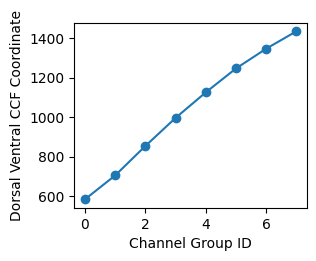

In [15]:
plt.figure(figsize=(3, 2.4))
plt.plot(group_dv_ccf.keys(), group_dv_ccf.values(), marker='o')
plt.xlabel('Channel Group ID')
plt.ylabel('Dorsal Ventral CCF Coordinate')
plt.show()

## Analysis

In [16]:
stimulus_presentations = session.stimulus_presentations

### drifting_gratings

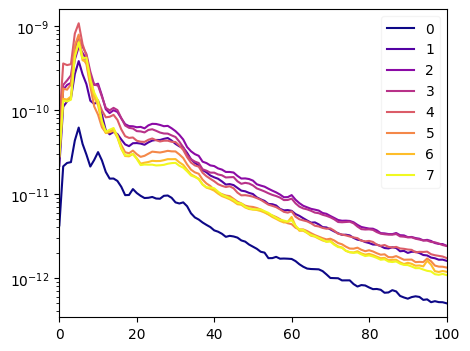

Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.6166, 69.2671, 2.0629                                     
                                                                                                  
                                       2 peaks were found:                                       

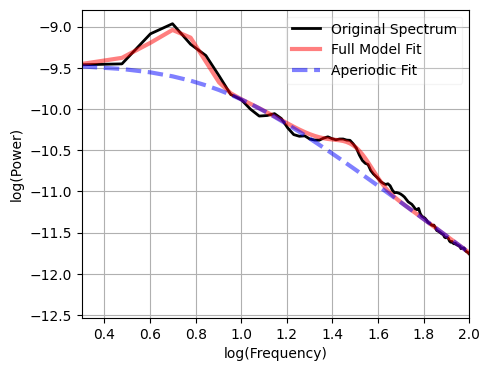

In [17]:
drifting_gratings_presentations, grating_ids, grating_times, grating_duration = align_gratings(
    stimulus_presentations, stimulus_name='drifting_gratings')
aligned_lfp = align_trials(lfp_array, grating_ids, grating_times, window=(0., grating_duration))
drifting_gratings_psd = trial_psd(aligned_lfp, tseg=1.)
psd_avg = drifting_gratings_psd.mean(dim='presentation_id')
_ = plot_channel_psd(psd_avg, channel_id=group_id, freq_range=200., plt_range=(0, 100.), figsize=(5, 4),
                     aperiodic_mode='knee', dB_threshold=3., max_n_peaks=10, plt_log=True)

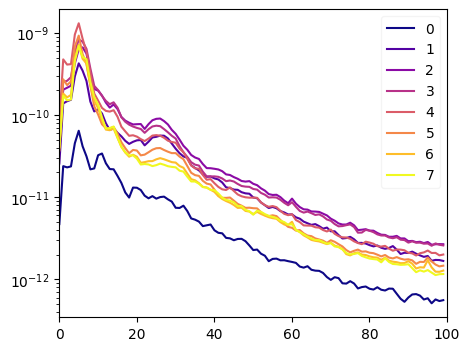

Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 2 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.5127, 71.1458, 2.1019                                     
                                                                                                  
                                       2 peaks were found:                                       

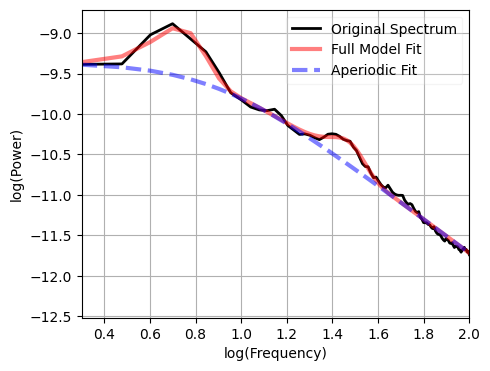

In [18]:
drifting_gratings_presentations, grating_ids, grating_times, grating_duration = align_gratings(
    stimulus_presentations, stimulus_name='drifting_gratings')
aligned_lfp = align_trials(lfp_array, grating_ids, grating_times, window=(0., 1.))
drifting_gratings_short_psd = trial_psd(aligned_lfp, tseg=1.)
psd_avg = drifting_gratings_short_psd.mean(dim='presentation_id')
_ = plot_channel_psd(psd_avg, channel_id=group_id, freq_range=200., plt_range=(0, 100.), figsize=(5, 4),
                     aperiodic_mode='knee', dB_threshold=3., max_n_peaks=10, plt_log=True)

### static_gratings

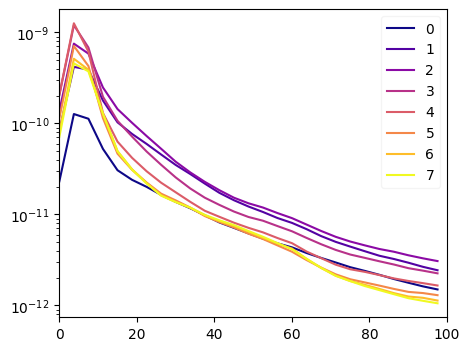

Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 7 - 199 Hz                        
                                 Frequency Resolution is 3.75 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -7.7921, 1.9907                                          
                                                                                                  
                                       0 peaks were found:                                       

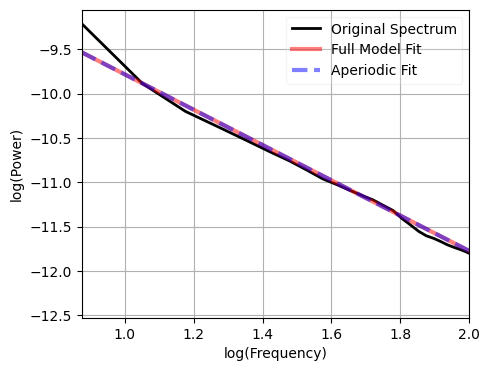

In [19]:
_, presentations_ids, presentations_times, trial_duration = align_gratings(stimulus_presentations, stimulus_name='static_gratings')
aligned_lfp = align_trials(lfp_array, presentations_ids, presentations_times, window=(0., trial_duration))
psd_avg = trial_psd(aligned_lfp, tseg=1.).mean(dim='presentation_id')
_ = plot_channel_psd(psd_avg, channel_id=group_id, freq_range=200., plt_range=(0, 100.), figsize=(5, 4),
                     aperiodic_mode='fixed', dB_threshold=3., max_n_peaks=10, plt_log=True)

### natural_scenes

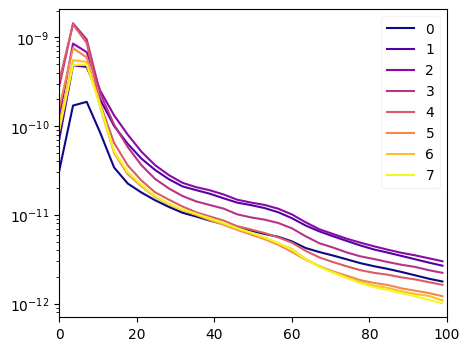

Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 7 - 198 Hz                        
                                 Frequency Resolution is 3.53 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -7.9644, 1.8940                                          
                                                                                                  
                                       0 peaks were found:                                       

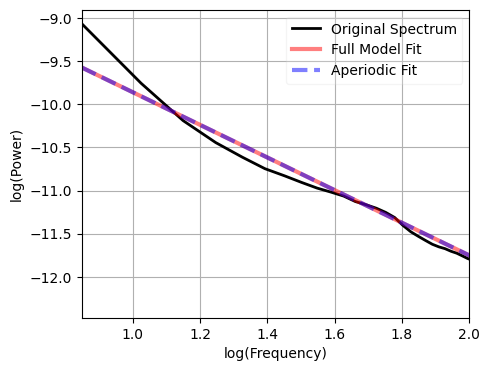

In [20]:
_, presentations_ids, presentations_times, trial_duration = align_scenes(stimulus_presentations, stimulus_name='natural_scenes')
aligned_lfp = align_trials(lfp_array, presentations_ids, presentations_times, window=(0., trial_duration))
psd_avg = trial_psd(aligned_lfp, tseg=1.).mean(dim='presentation_id')
_ = plot_channel_psd(psd_avg, channel_id=group_id, freq_range=200., plt_range=(0, 100.), figsize=(5, 4),
                     aperiodic_mode='fixed', dB_threshold=3., max_n_peaks=10, plt_log=True)

### natural_movie_one

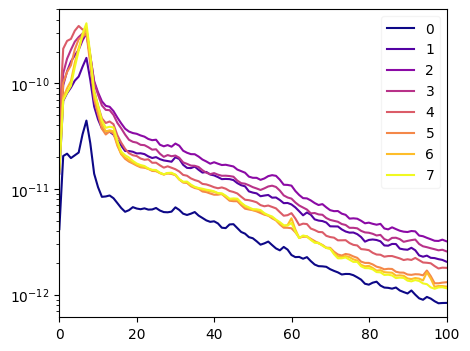

Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -8.2550, 24.8636, 1.7377                                     
                                                                                                  
                                       1 peaks were found:                                       

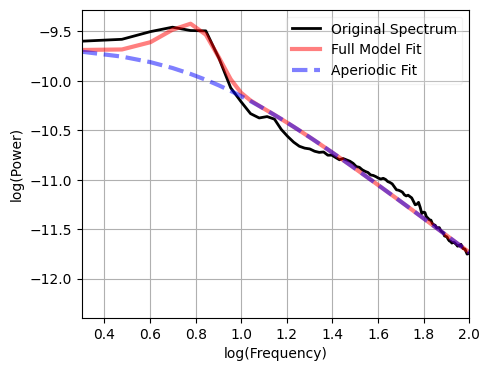

In [21]:
_, presentations_ids, presentations_times, trial_duration = align_movie(stimulus_presentations, stimulus_name='natural_movie_one')
aligned_lfp = align_trials(lfp_array, presentations_ids, presentations_times, window=(0., trial_duration))
psd_avg = trial_psd(aligned_lfp, tseg=1.).mean(dim='presentation_id')
_ = plot_channel_psd(psd_avg, channel_id=group_id, freq_range=200., plt_range=(0, 100.), figsize=(5, 4),
                     aperiodic_mode='knee', dB_threshold=3., max_n_peaks=10, plt_log=True)

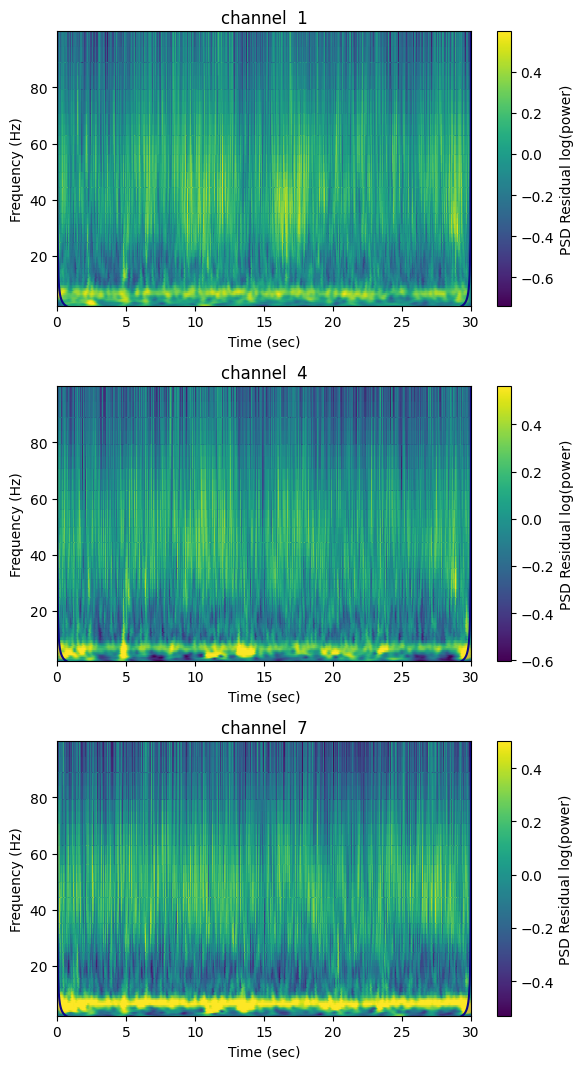

In [22]:
sxx_avg = trial_averaged_spectrogram(aligned_lfp, tseg=.5)
_ = plot_channel_spectrogram(sxx_avg, channel_id=[1, 4, 7], plt_range=(0, 100.), plt_log=True,
                             clr_freq_range=(30., 80.), figsize=(6, 3.6),
                             remove_aperiodic={'freq_range': 200., 'aperiodic_mode': 'knee'})

### natural_movie_three

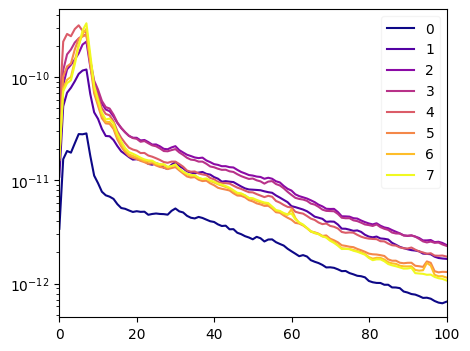

Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -8.3901, 16.1071, 1.6625                                     
                                                                                                  
                                       1 peaks were found:                                       

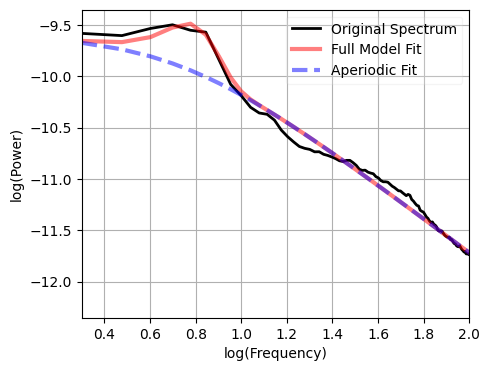

In [23]:
_, presentations_ids, presentations_times, trial_duration = align_movie(stimulus_presentations, stimulus_name='natural_movie_three')
aligned_lfp = align_trials(lfp_array, presentations_ids, presentations_times, window=(0., trial_duration))
psd_avg = trial_psd(aligned_lfp, tseg=1.).mean(dim='presentation_id')
_ = plot_channel_psd(psd_avg, channel_id=group_id, freq_range=200., plt_range=(0, 100.), figsize=(5, 4),
                     aperiodic_mode='knee', dB_threshold=3., max_n_peaks=10, plt_log=True)

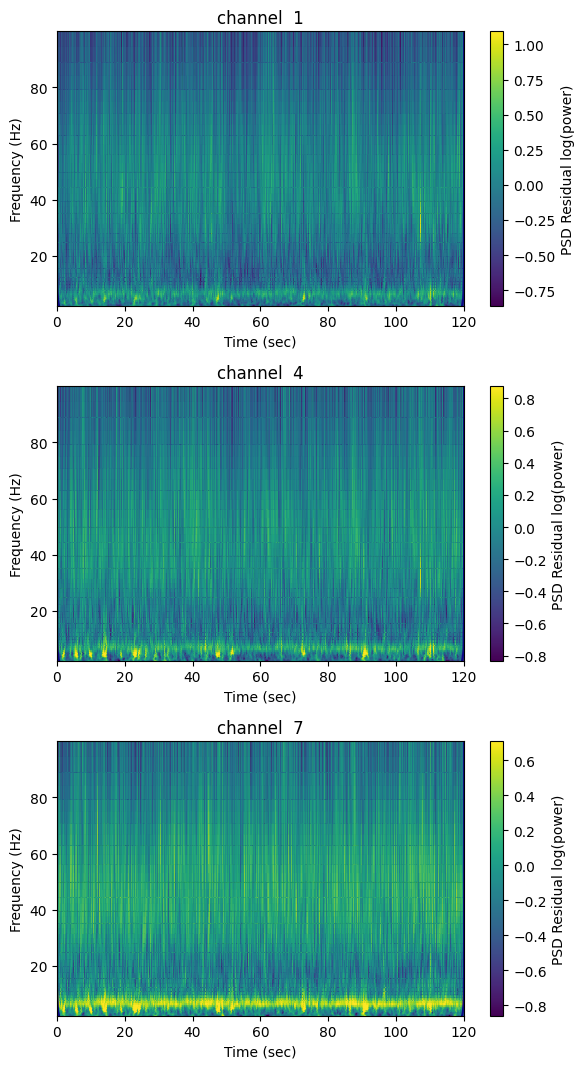

In [24]:
sxx_avg = trial_averaged_spectrogram(aligned_lfp, tseg=.5)
_ = plot_channel_spectrogram(sxx_avg, channel_id=[1, 4, 7], plt_range=(0, 100.), plt_log=True,
                             clr_freq_range=(30., 80.), figsize=(6, 3.6),
                             remove_aperiodic={'freq_range': 200., 'aperiodic_mode': 'knee'})

### drifting_gratings conditions

In [25]:
condition_id, cond_presentation_id = presentation_conditions(
    drifting_gratings_presentations, condtion_types=['orientation', 'temporal_frequency'])

drifting_gratings_cond_psd = [drifting_gratings_psd.sel(presentation_id=i).mean(dim='presentation_id') for i in cond_presentation_id.values()]
drifting_gratings_cond_psd = xr.concat(drifting_gratings_cond_psd, dim=pd.Index(cond_presentation_id, name='condition_id'))
drifting_gratings_cond_psd = drifting_gratings_cond_psd.sel(condition_id=condition_id)

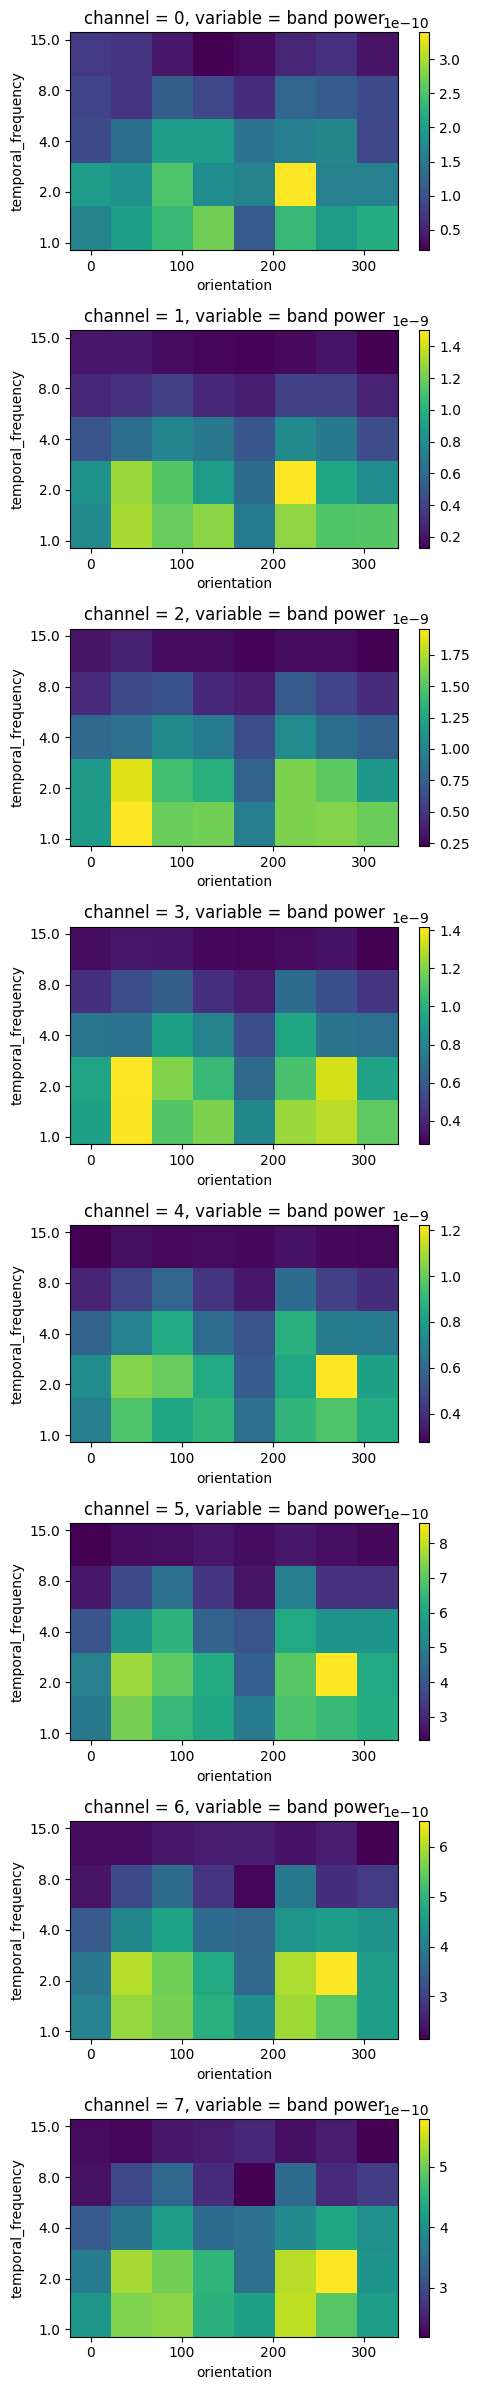

In [26]:
power_band = [20., 40.]
cond_band_power = drifting_gratings_cond_psd.sel(frequency=slice(*power_band)).integrate('frequency').rename(PSD='band power')

temporal_frequency = cond_band_power.temporal_frequency.values
nchannel = cond_band_power.dims['channel']

_, axs = plt.subplots(nchannel, 1, squeeze=False, figsize=(5, 3 * nchannel))
for c, ax in zip(cond_band_power.channel, axs.ravel()):
    cpower = cond_band_power.sel(channel=c).to_array()[0].T
    cpower.plot.imshow(ax=ax)
    ax.set_yticks(np.linspace(temporal_frequency[0], temporal_frequency[-1], temporal_frequency.size))
    ax.set_yticklabels(temporal_frequency)
plt.tight_layout()
plt.show()


temporal_frequency:  1.0 Hz


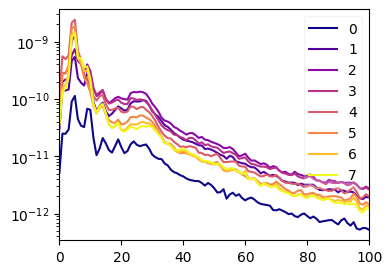

Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.5550, 49.8979, 2.0598                                     
                                                                                                  
                                       2 peaks were found:                                       

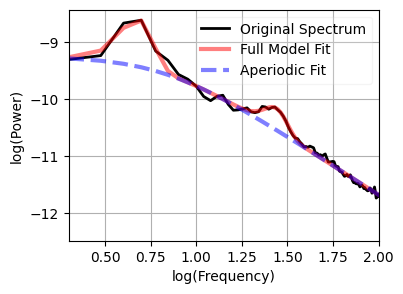


temporal_frequency:  2.0 Hz


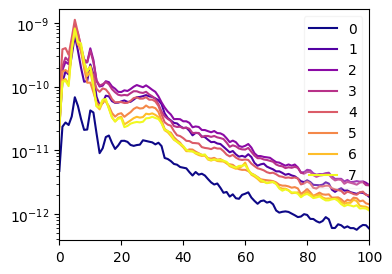

Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    -7.3807, 117.2095, 2.1556                                     
                                                                                                  
                                       2 peaks were found:                                       

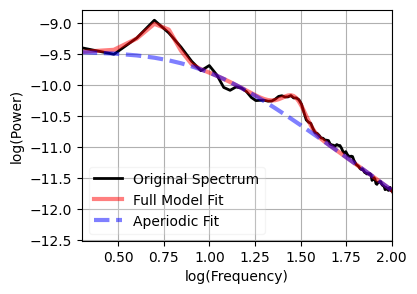


temporal_frequency:  4.0 Hz


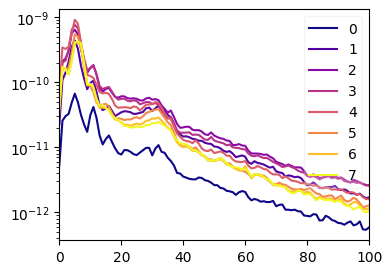

Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.5949, 80.1118, 2.0730                                     
                                                                                                  
                                       2 peaks were found:                                       

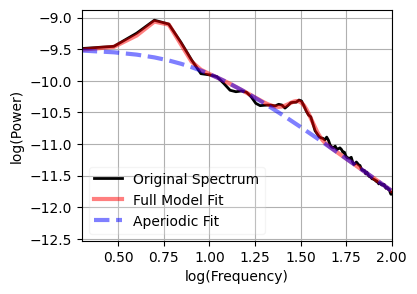


temporal_frequency:  8.0 Hz


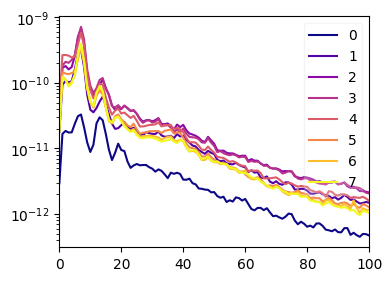

Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    -7.4725, 155.1826, 2.1475                                     
                                                                                                  
                                       1 peaks were found:                                       

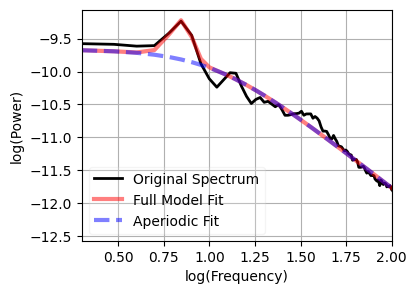


temporal_frequency:  15.0 Hz


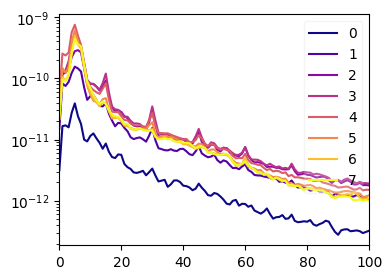

Channel:  4
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 1 - 200 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     -7.7890, 80.7679, 2.0222                                     
                                                                                                  
                                       2 peaks were found:                                       

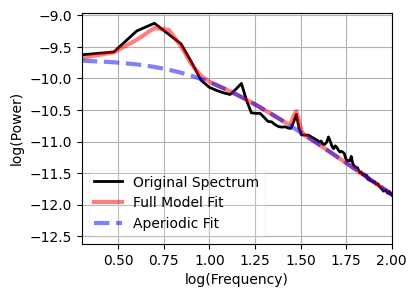

In [27]:
tfreq_psd = drifting_gratings_cond_psd.mean(dim='orientation')
for freq in drifting_gratings_cond_psd.temporal_frequency:
    print(f'\ntemporal_frequency: {freq: .1f} Hz')
    _ = plot_channel_psd(tfreq_psd.sel(temporal_frequency=freq), channel_id=group_id,
                         freq_range=200., plt_range=(0, 100.), figsize=(4, 3),
                         aperiodic_mode='knee', dB_threshold=3., max_n_peaks=10, plt_log=True)


temporal_frequency:  1.0 Hz


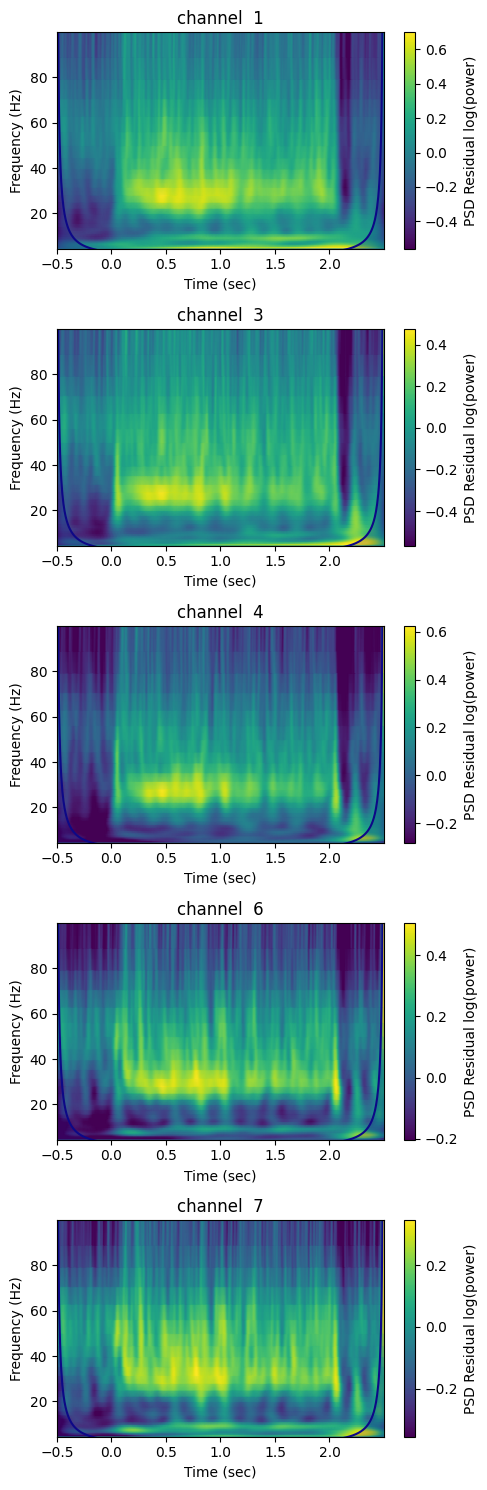


temporal_frequency:  2.0 Hz


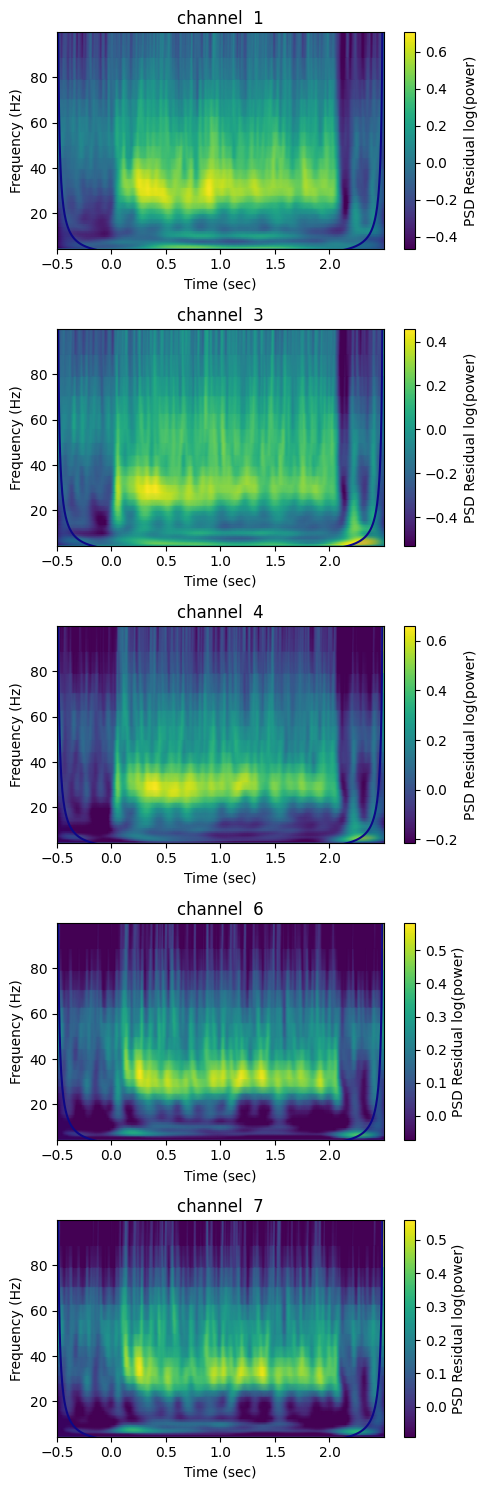


temporal_frequency:  4.0 Hz


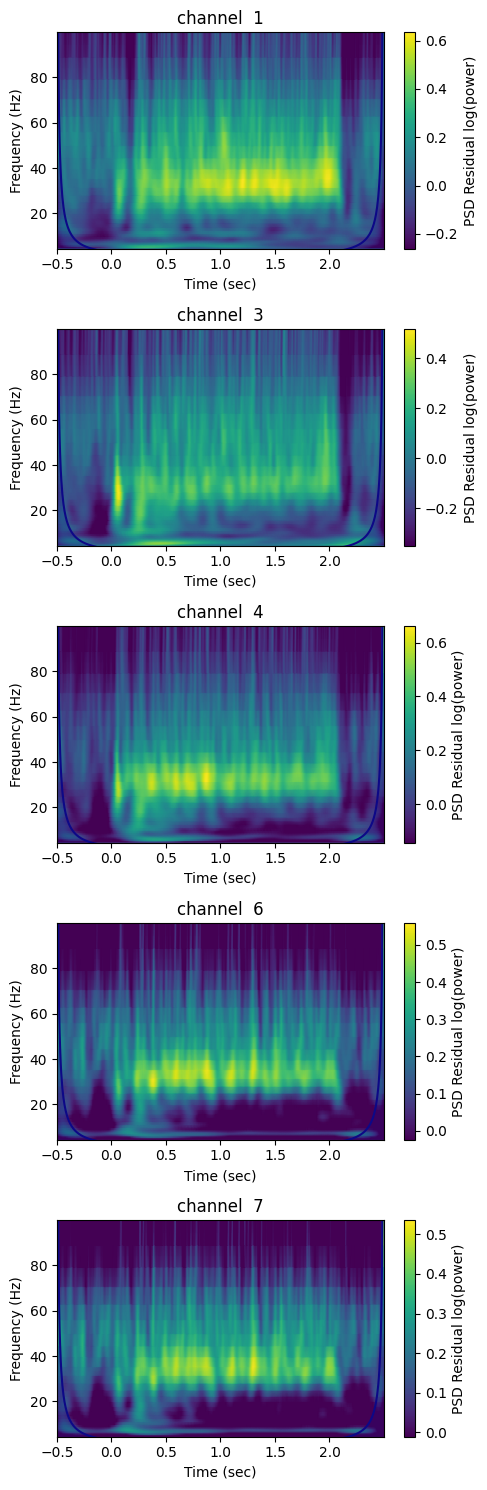


temporal_frequency:  8.0 Hz


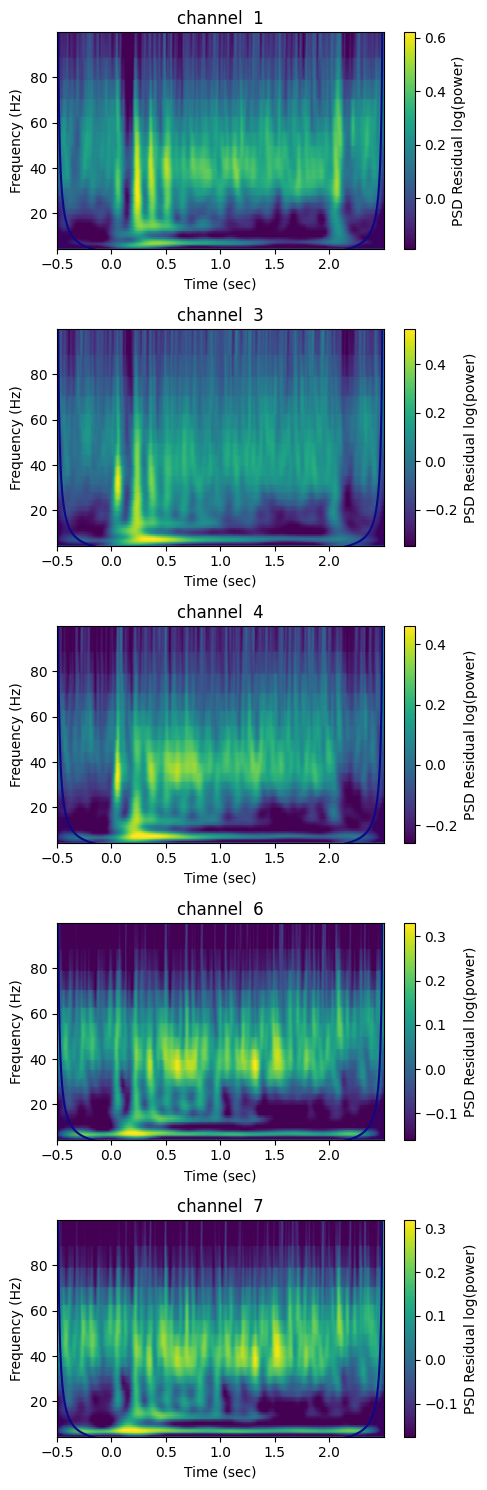


temporal_frequency:  15.0 Hz


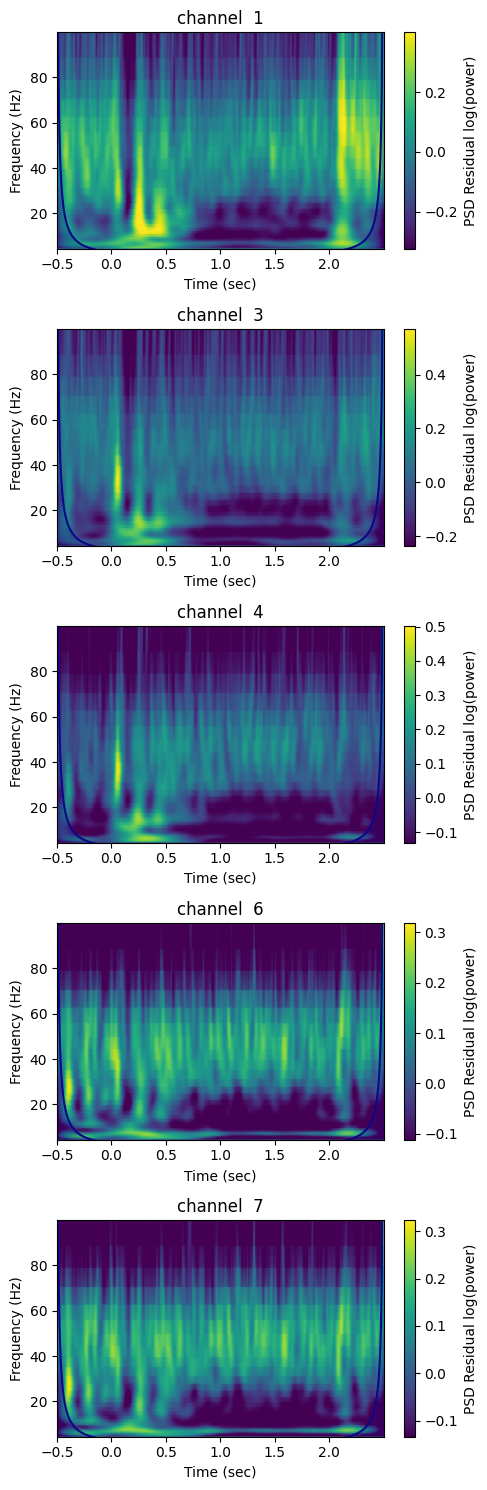

In [28]:
grating_aligned_lfp = align_trials(lfp_array, grating_ids, grating_times, window=(-0.5, grating_duration + 0.5))

for freq in condition_id.temporal_frequency:
    print(f'\ntemporal_frequency: {freq: .1f} Hz')
    present_ids = np.concatenate([cond_presentation_id[i] for i in condition_id.sel(temporal_frequency=freq).values])
    sxx_avg = trial_averaged_spectrogram(grating_aligned_lfp.sel(presentation_id=present_ids), tseg=.25)
    _ = plot_channel_spectrogram(sxx_avg, channel_id=[1, 3, 4, 6, 7], plt_range=(0, 100.), plt_log=True,
                                 clr_freq_range=(25., 40.), figsize=(5, 3),
                                 remove_aperiodic={'freq_range': 200., 'aperiodic_mode': 'knee'})